# Index eval code goes here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import os
import sys
from PIL import Image
import pandas as pd
import time

#rootdir = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/ind/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

In [2]:
cat_labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]
# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):    
    inds = [cat_labels.index(c)+243 for c in kwargs['category']] 
    # print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

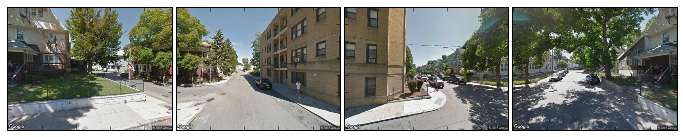

In [43]:
plt.figure(figsize = (12,4))
gs1 = gridspec.GridSpec(1, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(4):
    # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    image = Image.open(imgroot+'boston/42.298631,-71.0830938769_'+str(i)+'.png') 
    image = np.array(image)
    #ax1.imshow(getmask(image[:,:,3], category=['Sky']), cmap='gray')
    ax1.imshow(image)
    #plt.subp

plt.show()

In [8]:
def iter_dir(rootdir, dostuff):
    emptyfiles = [] 
    
    citynames = np.array(sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)]))
    for cityname in citynames[np.array([1,3,7,9])]:   ######################
        print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        
        lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir']).astype(str)############################################
        df1['city'] = cityname
        
        records = []
    
        for i in range(len(imgnames)): 
            img_filepath = citypath + "/" + imgnames[i] + ".png"
            if os.stat(img_filepath).st_size > 0:                
                image = Image.open(img_filepath) 
                records = records + [dostuff(image)]
            else:
                emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
        #print records        
        
        df2 = pd.DataFrame(records, columns = ["sky", 'tree'])
                           #columns=['D1h','D1s','D1v', 'D2h','D2s','D2v', 'Mh','Ms','Mv', "D1hex", 'D2hex', 'Mhex'])
        df = pd.concat([df1, df2], axis=1)
        df.to_csv(dataroot+'sky_tree_'+cityname+'.csv')

In [4]:
def cal_sky_tree(im):
    imarr = np.array(im)[:,:,3]    
    mask1 = np.sum(getmask(imarr, category=["Sky"]))
    mask2 = np.sum(getmask(imarr, category=["Tree"]))
    return (mask1,mask2)

In [9]:
image = Image.open(imgroot+'boston/42.298631,-71.0830938769_0.png') 
cal_sky_tree(image)

(9023, 70845)

In [10]:
iter_dir(imgroot, cal_sky_tree)

boston
chicago
newyork
sanfrancisco


### obsolete

In [ ]:
emptyfiles = []

df = pd.DataFrame()

citynames = sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)])
for cityname in citynames[:1]:   
    citypath = rootdir + cityname
    print citypath
    imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
    #print os.listdir(citypath)

    lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])

    df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir']).astype(str)################################################
    df1['city'] = cityname

    sky_area = np.zeros(len(imgnames))

    for i in range(len(imgnames)): 
        filepath = citypath + "/" + imgnames[i] + ".txt"
        if os.stat(filepath).st_size > 0:                
            ind = np.loadtxt(filepath)
            sky_area[i] = np.sum([(j==0) for j in np.nditer(ind)]) # number of pixels with the index of "0"
            del ind
        else:
            emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
            sky_area[i] = 0

    df1['sky_area'] = sky_area
    df = df.append(df1, ignore_index=True)

df[['lat', 'lng', 'dir']] = df[['lat', 'lng', 'dir']].astype(str)################################################
df.to_csv(rootdir+'sky_area'+'.csv')
np.savetxt(rootdir +'empty_files'+'.txt', emptyfiles, fmt="%s")
print str(len(emptyfiles)) + " files are empty"

/media/senseable-beast/beast-brain-1/Data/streetviewdata/ind/barcelona
0 files are empty


# post processing

In [20]:
skydf = pd.read_csv(dataroot+"sky_tree_pre_newyork.csv")

In [21]:
skydf = skydf[['lat','lng','dir','sky', 'tree']].astype(str)
skydf['sky'] = skydf['sky'].astype(float)
skydf['tree'] = skydf['tree'].astype(float)
skydf.head()

,lat,lng,dir,sky,tree
0,40.694283,-73.959170082,0,50564,29764
1,40.694283,-73.959170082,1,47239,1857
2,40.694283,-73.959170082,2,23788,679
3,40.694283,-73.959170082,3,47257,1815
4,40.694283,-73.9611500442,0,38156,6707


In [22]:
skymean = skydf.groupby(['lat','lng']).agg({'sky': np.mean, 'tree': np.mean}).reset_index()
skymean[['lat','lng']] = skymean[['lat','lng']].astype(str)
skymean.head()

,lat,lng,tree,sky
0,40.694283,-73.959170082,8528.75,42212.00
1,40.694283,-73.9611500442,2450.50,27803.25
2,40.694283,-73.9631300063,5612.75,20586.00
3,40.694283,-73.9651099685,18297.75,18843.00
4,40.694283,-73.9670899306,5909.25,27950.00


In [23]:
skymean.to_csv(dataroot+"sky_tree_newyork.csv")

# below are trials

In [16]:
emptyfiles = []

def cal_sky_area():
    rootdir = 'C:/Users/lezhi/Dropbox/thesis/indfake/'
    df = pd.DataFrame()

    citynames = sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)])
    for cityname in citynames:   
        citypath = rootdir + cityname
        print citypath
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        #print os.listdir(citypath)

        lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])

        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir'])
        df1['city'] = cityname

        sky_area = np.zeros(len(imgnames))
        
        for i in range(len(imgnames)): 
            filepath = citypath + "/" + imgnames[i] + ".txt"
            if os.stat(filepath).st_size > 0:                
                ind = np.loadtxt(filepath)
                sky_area[i] = np.sum([(j==0) for j in np.nditer(ind)]) # number of pixels with the index of "0"
                del ind
            else:
                emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
                sky_area[i] = 0

        df1['sky_area'] = sky_area
        df = df.append(df1, ignore_index=True)

    df.to_csv('C:/Users/lezhi/Dropbox/thesis/'+'sky_area'+'.csv')
    print str(len(emptyfiles)) + " files are empty"

In [17]:
cal_sky_area()

C:/Users/lezhi/Dropbox/thesis/indfake/barcelona


KeyboardInterrupt: 

In [3]:
labels = ["Sky", "Building", "Pole", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist", "Unlabelled"]

# trial for single image

In [2]:
def cal_sky_area(citypath,imgname):
    ind = np.loadtxt(citypath + "/" + imgname + ".txt")
    return np.sum([(i==0) for i in np.nditer(ind)]) # number of pixels with the index of "0"

In [8]:
imdir = 'C:/Users/lezhi/Dropbox/thesis/img2/barcelona/41.404298,2.13597899993_2.png'

In [9]:
ind = np.loadtxt('testind.txt')
img = Image.open(imdir)

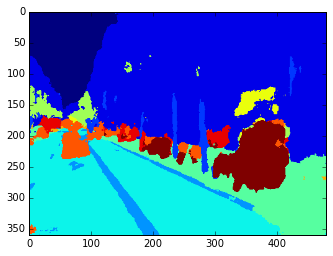

In [10]:
plt.imshow(ind)

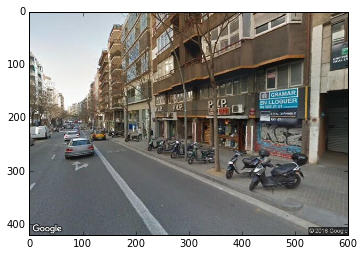

In [11]:
plt.imshow(img)

In [19]:
np.sum([(i==0) for i in np.nditer(ind)]) # number of pixels with the index of "0"

14048

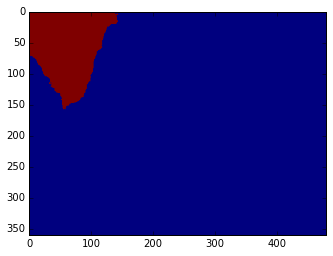

In [21]:
plt.imshow(np.array([(i==0) for i in np.nditer(ind)]).reshape((360,480)))

In [17]:
np.sum([1 for i in np.nditer(ind)]) # total number of pixels

172800